In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
# from skimage.measure import profile_line
# from joblib import Parallel, delayed

olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ncore = 48
if ncore > mp.cpu_count():
    ncore = mp.cpu_count()
ncore

48

# Workflow starts here!

In [4]:
###################### need to change start
ipts="19458"
###################### need to change end

## Find CT scan location

In [5]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
os.listdir(ct_loc)

['ob_crop', 'dc_crop', 'ct_scans_half', 'ct_scans_crop']

## Find OB location

In [6]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
os.listdir(ob_loc)

['ob_crop', 'dc_crop', 'ct_scans_half', 'ct_scans_crop']

## Find DC location

In [7]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
os.listdir(dc_loc)

['ob_crop', 'dc_crop', 'ct_scans_half', 'ct_scans_crop']

In [8]:
###################### need to change start
sample_name = "ct_scans_half"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "ob_crop")
dc_dir = os.path.join(dc_loc, "dc_crop")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + ".h5"
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 900 of angle 180.0
Found index of 0 degree projections: 0 of angle 0.0
Loading 1801 CT projections...


1801it [01:27, 20.52it/s]


1801 CT projections loaded!
Shape: (1801, 2048, 590)
Loading 20 Open Beam (OB) images...


20it [00:00, 20.98it/s]


20 Open Beam (OB) images loaded!
Shape: (20, 2048, 590)
Loading 11 Dark Current (DC) images...


11it [00:00, 21.57it/s]

11 Dark Current (DC) images loaded!
Shape: (11, 2048, 590)


# Visual verification of loaded files

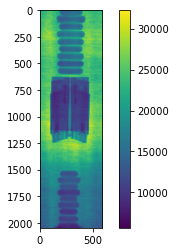

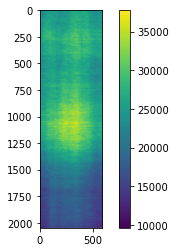

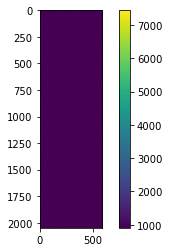

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


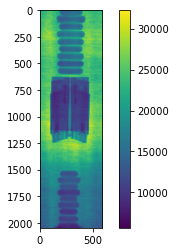

In [11]:
###################### need to change start
crop = False
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 0
crop_right = 600
crop_top = 0
crop_bottom = 2048
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)

Time: 31.40921053593047 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(1801, 2048, 590)


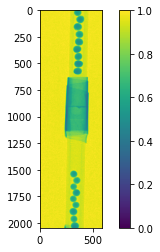

In [13]:
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


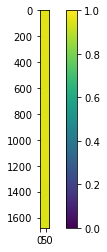

In [14]:
###################### need to change start
bg_left = 5
bg_right = 80
bg_top = 20
bg_bottom = 1700
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

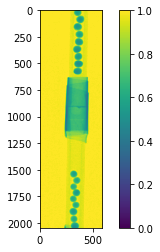

Time: 27.6401158538647 s


In [15]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

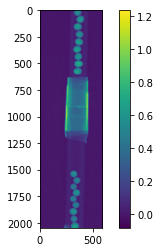

In [16]:
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)

# Find and correct tilt

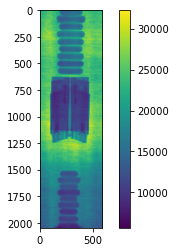

(2048, 590)

In [17]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


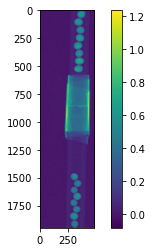

Tilt correction ROI at 180 degree (flipped):


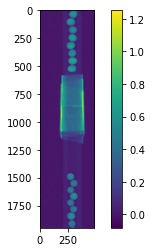

In [19]:
###################### need to change start
tt_left = 10
tt_right = 500
tt_top = 50
tt_bottom = 2000
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_000deg_trans = proj_norm[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_trans = proj_norm[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree (flipped):")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(np.fliplr(tt_180deg_mlog))
plt.colorbar()
plt.show()

In [20]:
print("Finding the tilt angle using transmission images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_trans, image180=tt_180deg_trans)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using transmission images...
Found the tilt angle:  -0.7253218490992547


In [21]:
print("Finding the tilt angle using minus log images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using minus log images...
Found the tilt angle:  -0.7256422310429781


Projection at 0 degree:


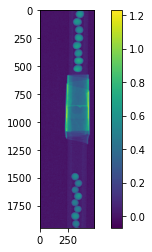

Projection at 180 degree (flipped):


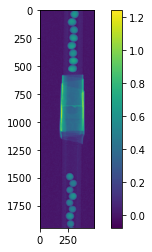

In [22]:
print("Projection at 0 degree:")
# proj_mlog_tilt_000deg_mlog = tilt.apply_tilt_correction(proj_mlog[proj000_idx], tilt_ang.x, ncore=ncore)
# proj_mlog_tilt_180deg_mlog = tilt.apply_tilt_correction(proj_mlog[proj180_idx], tilt_ang.x, ncore=ncore)
proj_mlog_tilt_000deg_mlog = tilt.apply_tilt_correction(tt_000deg_mlog, tilt_ang.x, ncore=ncore)
proj_mlog_tilt_180deg_mlog = tilt.apply_tilt_correction(tt_180deg_mlog, tilt_ang.x, ncore=ncore)
plt.imshow(proj_mlog_tilt_000deg_mlog)# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog_tilt_180deg_mlog))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [23]:
t0 = timeit.default_timer()
# tilt_ang.x = -0.7256422310429781
proj_mlog_tilt = proj_mlog[:]
for e_idx in range(proj_mlog.shape[0]):
    proj_mlog_tilt[e_idx] = tilt.apply_tilt_correction(proj_mlog[e_idx], tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'tilt_corr_roi', tt_roi_dict)
history_dict = rocku.log(history_dict, 'tilt_corr', tilt_ang.x)

Time cost 0.8889124139483707 min


# Ring Artifact Removal

Before ring removal:


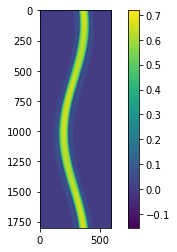

In [24]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (a) Vo's approach from tomopy

In [ ]:
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
t0 = timeit.default_timer()
proj_mlog_rmv_vo = tomopy.remove_all_stripe(proj_mlog_tilt, ncore=ncore, nchunk=nchunk)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'Vo')

In [ ]:
slice_num = 200
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (b) bm3d approach

In [ ]:
# t0 = timeit.default_timer()
# results = Parallel(n_jobs=16, prefer="threads")(delayed(ndi.gaussian_filter)(data[:, i, :], (3, 5), 0) for i in range(n_slice))
# t1 = timeit.default_timer()

In [25]:
t0 = timeit.default_timer()
print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.
Denoising sinogram 0
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 15
k: 3
k: 2
k: 1
k: 0
Denoising sinogram

k: 2
k: 1
k: 0
Denoising sinogram 186
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 187
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 188
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 189
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 190
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 191
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 192
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 193
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 194
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 195
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 196
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 197
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 198
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 199
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 200
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 201
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 202
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 203
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 204
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 205
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 206
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 207
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 208
k: 3
k: 2
k: 1
k

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 377
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 378
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 379
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 380
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 381
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 382
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 383
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 384
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 385
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 386
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 387
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 388
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 389
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 390
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 391
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 392
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 393
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 394
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 395
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 396
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 397
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 398
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 399
k: 3
k: 2
k

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 568
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 569
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 570
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 571
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 572
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 573
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 574
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 575
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 576
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 577
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 578
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 579
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 580
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 581
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 582
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 583
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 584
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 585
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 586
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 587
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 588
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 589
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 590
k: 3
k: 2
k

k: 2
k: 1
k: 0
Denoising sinogram 759
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 760
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 761
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 762
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 763
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 764
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 765
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 766
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 767
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 768
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 769
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 770
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 771
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 772
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 773
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 774
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 775
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 776
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 777
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 778
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 779
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 780
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 781
k: 3
k: 2
k: 1
k

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 950
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 951
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 952
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 953
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 954
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 955
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 956
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 957
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 958
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 959
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 960
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 961
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 962
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 963
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 964
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 965
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 966
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 967
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 968
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 969
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 970
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 971
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 972
k: 3
k: 2
k

k: 0
Denoising sinogram 1137
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1138
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1139
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1140
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1141
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1142
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1143
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1144
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1145
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1146
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1147
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1148
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1149
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1150
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1151
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1152
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1153
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1154
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1155
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1156
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1157
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1158
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1159
k: 

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1324
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1325
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1326
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1327
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1328
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1329
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1330
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1331
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1332
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1333
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1334
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1335
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1336
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1337
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1338
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1339
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1340
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1341
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1342
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1343
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1344
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1345
k: 3
k: 2
k: 1
k: 0
Denoising si

k: 1
k: 0
Denoising sinogram 1510
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1511
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1512
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1513
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1514
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1515
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1516
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1517
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1518
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1519
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1520
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1521
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1522
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1523
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1524
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1525
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1526
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1527
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1528
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1529
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1530
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1531
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 153

Denoising sinogram 1696
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1697
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1698
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1699
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1700
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1701
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1702
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1703
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1704
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1705
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1706
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1707
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1708
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1709
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1710
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1711
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1712
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1713
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1714
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1715
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1716
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1717
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1718
k: 3
k: 

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1883
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1884
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1885
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1886
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1887
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1888
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1889
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1890
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1891
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1892
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1893
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1894
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1895
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1896
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1897
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1898
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1899
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1900
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1901
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1902
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1903
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1904
k: 3
k: 2
k: 1
k: 0
Denoising si

Before ring removal:


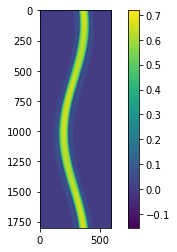

After ring removal:


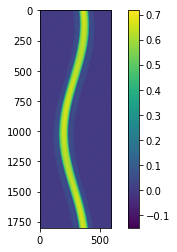

Difference:


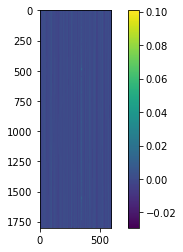

In [26]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [28]:
# proj_mlog_to_recon = proj_mlog_rmv_vo.astype(np.float32)
proj_mlog_to_recon = proj_mlog_rmv_bm3d.astype(np.float32)
sino_norm = np.moveaxis(proj_norm, 1, 0)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

In [29]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog_to_recon[proj000_idx,:,:]), np.squeeze(proj_mlog_to_recon[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 278.0


In [30]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 277.43043518066406


# Reconstruction

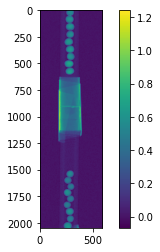

In [31]:
plt.imshow(proj_mlog_to_recon[600])
plt.colorbar()
plt.show()

277.43043518066406


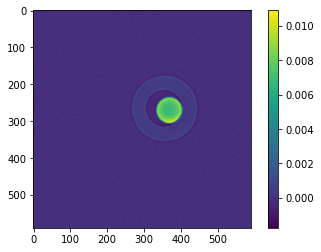

In [34]:
print(rot_center)
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[1600], rot_center, angles=ang_rad, apply_log=False)
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

In [35]:
proj_mlog_to_recon.shape

(1801, 2048, 590)

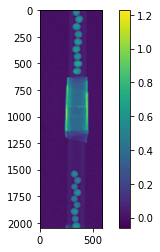

In [36]:
subset = False
# subset = True
if subset:
    _proj_mlog_to_recon = rocku.crop(proj_mlog_to_recon, 0, proj_mlog_to_recon.shape[2]-1, 600, 1200, subset)
else:
    _proj_mlog_to_recon = proj_mlog_to_recon[:]
plt.imshow(_proj_mlog_to_recon[1])
plt.colorbar()
plt.show()

In [37]:
t0 = timeit.default_timer()
recon_algo = 'gridrec'
########## tomopy
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
recon = tomopy.recon(_proj_mlog_to_recon, ang_rad, center=rot_center, algorithm=recon_algo, ncore=ncore, nchunk=nchunk)
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)

Chunk size:  38
Time cost 0.2671208114363253 min


# Crop recon

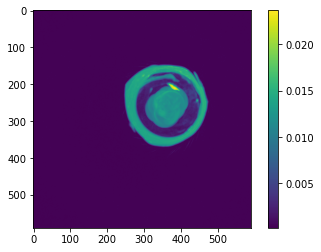

In [42]:
recon_max = np.max(recon, axis=0)
plt.imshow(recon_max)
plt.colorbar()
plt.show()

Recon ROI:


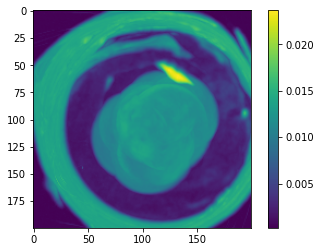

In [50]:
###################### need to change start
recon_crop = True
recon_crop_left = 250
recon_crop_right = 450
recon_crop_top = 150
recon_crop_bottom = 350
###################### need to change end
recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
recon_crop_roi_dict = {
    'left': recon_crop_left,
    'right': recon_crop_right,
    'top': recon_crop_top,
    'bottom': recon_crop_bottom
}
print("Recon ROI:")
plt.imshow(recon_max_crop)
plt.colorbar()
plt.show()

In [51]:
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
if recon_crop:
    history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

# Convert to attenuation co. (/cm)

In [53]:
# pix_um = 42.7 #um
pix_um = 37 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm
history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)

# Export recon files

In [54]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_all"
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)

# Export to HDF5

In [55]:
history_dict

{'crop': False,
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 80, 'top': 20, 'bottom': 1700},
 'minus_log': True,
 'tilt_corr_roi': {'left': 10, 'right': 500, 'top': 50, 'bottom': 2000},
 'tilt_corr': -0.7256422310429781,
 'ring_removal': 'bm3d',
 'rot_center': 277.43043518066406,
 'recon_algo': 'gridrec',
 'pixel_size_um': 37,
 'recon_crop': True,
 'recon_crop_roi': {'left': 250, 'right': 450, 'top': 150, 'bottom': 350}}

In [56]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=('cm-1',))
    f.create_dataset('tomo/recon/recon_volume', data=recon_cm)